In [1]:
from zeno_client import ZenoClient, ZenoMetric
import pandas as pd
import json
import os
from dotenv import load_dotenv

load_dotenv(override=True)

False

In [2]:
root_dir = '/data/user_data/jhsia2/dbqa'
results_dir = os.path.join(root_dir, 'reader_results')
client = ZenoClient('zen_EZ7LuqItWgObcQmIvNZVytvhtTh8JMs2HrSzzfXsiIg')


In [3]:
with open('/data/user_data/jhsia2/dbqa/data/id2title.json', 'r') as file:
    # Use json.dump to write the list of dictionaries to the file
    id2title = json.load(file)

In [4]:
dataset = 'nq'

In [18]:
project = client.create_project(
    name=f"Document QA - {dataset}",
    view={
        "data": {"type": "text", 
                 "label": "question:"
                },
        "label": {"type": "text"},
        "output": {
            "type": "vstack",
            "keys": {
                "gold answer set": {"type": "text", "label": "gold answer set: "},
                "gold title set": {"type": "text", "label": "gold title set: "},
                # "gold context set": {"type": "text", "label": "gold text set: "},
                "answer": {"type": "text", "label": "reader answer: "},
                "retrieved context": {
                    "type": "list",
                    "elements": {
                        "type": "vstack",
                        "keys": {
                            "score": {"type": "text", "label": "score: "},
                            "wiki_id": {"type": "markdown"},
                            "text": {"type": "text", "label": "text: "},
                            "wiki_id_match": {"type": "text", "label": "wiki_id match: "},
                            "wiki_par_id_match": {"type": "text", "label": "wiki_par_id match: "}
                        },
                    },
                    "collapsible": "bottom",
                    "border": True,
                    "pad": True,
                },
            },
        },
    },
    description="Document-grounded question answering with Wikipedia",
    metrics=[
        ZenoMetric(name="max retrieved score", type="mean", columns=["max_score"]),
        ZenoMetric(name="avg retrieved score", type="mean", columns=["avg_score"]),
        ZenoMetric(name="exact_match", type="mean", columns=["exact_match"]),
        ZenoMetric(name="f1", type="mean", columns=["f1"]),
        ZenoMetric(name="gold wiki_par_id set size", type="mean", columns=["gold wiki_par_id set size"]),
        ZenoMetric(name="substring_match", type="mean", columns=["substring_match"]),
        ZenoMetric(name="any wiki_id_match", type="mean", columns=["any wiki_id_match"]),
        ZenoMetric(name="any wiki_par_id_match", type="mean", columns=["any wiki_par_id_match"]),
        ZenoMetric(name="precision - wiki_id_match", type="mean", columns=["precision wiki_id_match"]),
        ZenoMetric(name="precision - wiki_par_id_match", type="mean", columns=["precision wiki_par_id_match"]),
        ZenoMetric(name="recall - wiki_id_match", type="mean", columns=["recall wiki_id_match"]),
        ZenoMetric(name="recall - wiki_par_id_match", type="mean", columns=["recall wiki_par_id_match"]),
        # ZenoMetric(name="true precision - wiki_id_match", type="mean", columns=["true precision wiki_id_match"]),
        # ZenoMetric(name="true precision - wiki_par_id_match", type="mean", columns=["true precision wiki_par_id_match"]),
        # ZenoMetric(name="true recall - wiki_id_match", type="mean", columns=["true recall wiki_id_match"]),
        # ZenoMetric(name="true recall - wiki_par_id_match", type="mean", columns=["true recall wiki_par_id_match"]),
    ],
)

Successfully updated project.
Access your project at  https://hub.zenoml.com/project/jhsia2/Document%20QA%20-%20nq


In [6]:
# datasets = ['nq', 'hotpotqa']
gold_data = []
# for dataset in datasets:
with open(os.path.join(root_dir, 'data', f"gold-{dataset}-dev-kilt.json"), "r") as f:
    data = json.load(f)
for d in data:
    d['dataset'] = dataset
print(len(data))
gold_data = gold_data + sorted(data, key=lambda x: x["id"])
# gold_answer_set, gold_wiki_par_id_set, gold_wiki_par_text_set, gold_title_set = get_gold_sets(gold_data)


2837


avg 2.2217130771942193 std 1.1900098894511266 min 1 max 12


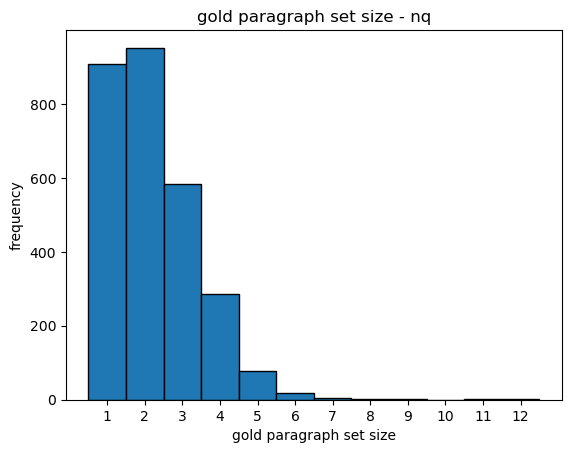

avg 1.6270708494888968 std 0.831067737513196 min 1 max 5


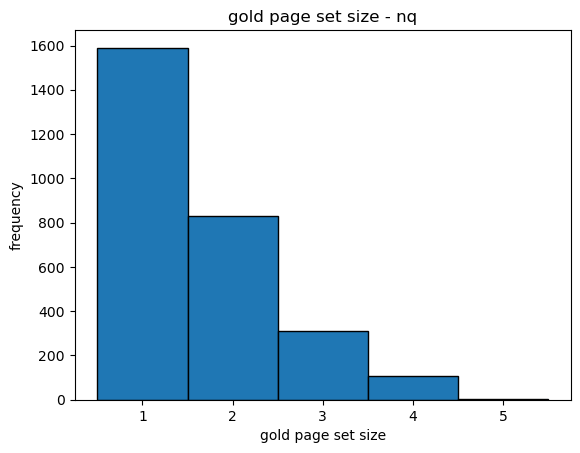

In [15]:
wiki_par_id_set_size = []
wiki_id_set_size = []
for d in gold_data:
    wiki_par_id_set_size.append(len(d['output']['wiki_par_id_set']))
    wiki_id_set_size.append(len(d['output']['wiki_id_set']))
    
import numpy as np

import matplotlib.pyplot as plt
def get_hist_info(size_set, unit):
    print('avg', np.mean(size_set), 'std', np.std(size_set), 'min', np.min(size_set), 'max', np.max(size_set))
        # gold_wiki_size = [len(s) for s in gold_wiki_par_id_set]

    plt.hist(size_set, bins=np.arange(min(size_set)-0.5, max(size_set)+1.5, 1), edgecolor='black')

    # Set the labels and title for the plot
    plt.xlabel(f'gold {unit} set size')
    plt.ylabel('frequency')
    plt.title(f'gold {unit} set size - {dataset}')

    # Set x-ticks to correspond to the integer values
    plt.xticks(range(min(size_set), max(size_set) + 1))

    # Display the plot
    plt.show()
    
get_hist_info(wiki_par_id_set_size, unit = 'paragraph')
get_hist_info(wiki_id_set_size, unit = 'page')

In [16]:
# data_df = pd.DataFrame({"question": [d["input"] for d in gold_data], 'id': [d['id'] for d in gold_data]})
# project.upload_dataset(data_df, id_column="id", data_column="question")

In [17]:
def get_precision(guess_wiki_id_set, gold_wiki_id_set):
    precision = np.mean([[s in gold_wiki_id_set] for s in guess_wiki_id_set])
    return precision
def get_recall(guess_wiki_id_set, gold_wiki_id_set):
    # print(guess_wiki_id_set)
    # print(gold_wiki_id_set)
    recall = np.mean([[s in guess_wiki_id_set] for s in gold_wiki_id_set]) if len(gold_wiki_id_set) > 0 else 0.0
    return recall

In [14]:
import numpy as np
def get_reader_df(top_k, combined_data):
    return pd.DataFrame(
        {
            "question": [d['input'] for d in combined_data],
            "dataset": [d['dataset'] for d in combined_data],
            "id": [d['id'] for d in combined_data],
            "output": [
                json.dumps(
                    {   
                        "gold answer set": ', '.join(d['gold_answer_set']),
                        "gold title set": ', '.join(d['gold_title_set']),
                        # "gold context set": '\n'.join(d['gold_text_set']),
                        # "gold context": d['gold_context'],
                        "answer": d["output"]["answer"],
                        "retrieved context": [
                            {
                                # "wiki_id": None,
                                # "text": None,
                                # "score": None,
                                # "wiki_id_match": None,
                                # "wiki_par_id_match": None
                            }
                        ] if top_k == 'baseline' else [
                            {
                                "wiki_id": "[{idx}]({url})".format(
                                    idx=id2title[r["wiki_id"]],
                                    url="https://en.wikipedia.org/?curid="
                                    + r["wiki_id"],
                                ),
                                "text": r["text"],
                                "score": r["score"],
                                "wiki_id_match": r["wiki_id_match"],
                                "wiki_par_id_match": r["wiki_par_id_match"]
                            }
                        for r in d["output"]["retrieved"]
                        ],
                    }
                )
                for d in combined_data
            ],
            
            "gold wiki_par_id set size": [
                len(d["gold_wiki_par_id_set"]) for d in combined_data
            ],
            "max_score": [0 for d in combined_data] if top_k == 'baseline' else [
                d["output"]["retrieved"][0]["score"] for d in combined_data
            ],
            "avg_score": [0 for d in combined_data] if top_k == 'baseline' else [
                np.mean([r["score"] for r in d["output"]["retrieved"]]) for d in combined_data
            ],
            "f1": [
                d["output"]["answer_evaluation"]["f1"] for d in combined_data
            ],
            "exact_match": [
                d["output"]["answer_evaluation"]["exact_match"] for d in combined_data
            ],
            "substring_match": [
                d["output"]["answer_evaluation"]["substring_match"] for d in combined_data
            ],
            "any wiki_id_match": [False for d in combined_data] if top_k == 'baseline' else [
                d["output"]["summary context evaluation"]["wiki_id_match"] for d in combined_data
            ],
            "any wiki_par_id_match": [False for d in combined_data] if top_k == 'baseline' else [
                d["output"]["summary context evaluation"]["wiki_par_id_match"] for d in combined_data
            ],
            "precision wiki_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_precision(set([r["wiki_id"] for r in d["output"]["retrieved"]]), d['gold_wiki_id_set']) for d in combined_data
            ],
            "precision wiki_par_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_precision(set([r["wiki_par_id"] for r in d["output"]["retrieved"]]), d['gold_wiki_par_id_set']) for d in combined_data
            ],
            "recall wiki_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_recall(set([r["wiki_id"] for r in d["output"]["retrieved"]]), d['gold_wiki_id_set']) for d in combined_data
            ],
            "recall wiki_par_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
                get_recall(set([r["wiki_par_id"] for r in d["output"]["retrieved"]]), d['gold_wiki_par_id_set']) for d in combined_data
            ],
            # "true precision wiki_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
            #     get_precision(set([r["wiki_id"][:d['truncated_num_docs']] for r in d["output"]["retrieved"]]), d['gold_wiki_id_set']) for d in combined_data
            # ],
            # "true precision wiki_par_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
            #     get_precision(set([r["wiki_par_id"][:d['truncated_num_docs']] for r in d["output"]["retrieved"]]), d['gold_wiki_par_id_set']) for d in combined_data
            # ],
            # "true recall wiki_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
            #     get_recall(set([r["wiki_id"][:d['truncated_num_docs']] for r in d["output"]["retrieved"]]), d['gold_wiki_id_set']) for d in combined_data
            # ],
            # "true recall wiki_par_id_match": [0 for d in combined_data] if top_k == 'baseline' else [
            #     get_recall(set([r["wiki_par_id"][:d['truncated_num_docs']] for r in d["output"]["retrieved"]]), d['gold_wiki_par_id_set']) for d in combined_data
            # ]
        }
    )
    # return output_df
# output_df["id"] = 

In [15]:
def combine_gold_and_compiled(output_data, gold_data):
    
    for i, (od, gd) in enumerate(zip(output_data, gold_data)):
        # print(i)
        # print('output', od)
        # print('gold', gd)
        if(od['id'] != gd['id']):
            print(od, gd)
            break
        # od['gold_title_set'] = gd['output']['answer_set']
        od['dataset'] = gd['dataset']
        od['gold_answer_set'] = gd['output']['answer_set']
        od['gold_wiki_id_set'] = gd['output']['wiki_id_set']
        od['gold_wiki_par_id_set'] = gd['output']['wiki_par_id_set']
        od['gold_title_set'] = gd['output']['title_set']
    return output_data

In [16]:
def combine_truncated_stats(combined_data, truncated_reader_stats):
    for (c,t) in zip(combined_data, truncated_reader_stats):
        c['truncated_num_docs'] = t['num_docs']
    return combined_data

In [20]:
reader_models = ['llama_7b', 'flanUl2']
# reader_models = ['flanT5']
retriever_models = ['bm25', 'colbert']
# retriever_models = ['colbert']
top_ks= ["baseline", "top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]
# top_ks = ['top1']
# top_k = 'baseline'
# truncate_stats = {'flanT5': [], 'llama': []}
# for retriever_model in retriever_models:
    # t5  = []
    # llama = []
    # with open(f'/data/user_data/jhsia2/dbqa/retriever_results/predictions/{retriever_model}/{dataset}-truncation.json', 'r') as file:
    #     docs = json.load(file)
    #     for d in docs:
    #         truncate_stats['flanT5'].append({'id': d['id'], 'num_docs': d['t5_truncation']})
    #         truncate_stats['llama'].append({'id': d['id'], 'num_docs': d['llama_truncation']})
for retriever_model in retriever_models:
    for reader_model in reader_models:
    
        print('retriever', retriever_model)
        print('reader', reader_model)
        for top_k in top_ks:
            print(top_k)
            data = []
            with open(os.path.join(results_dir, reader_model, dataset, retriever_model, f"{top_k}/reader_results_zeno.json"), "r") as f:
                data = data + json.load(f)
                    
            combined_data = combine_gold_and_compiled(data, gold_data)
            # combined_data = combine_truncated_stats(combined_data, truncate_stats[reader_model])
            # if (top_k != 'baseline'):
            output_df = get_reader_df(top_k, combined_data)
            # else:
            #     output_df = get_baseline_df(combined_data)
            # break
            if top_k == 'baseline':
                project.upload_system(
                output_df, name= (reader_model + ' ' + top_k), id_column="id", output_column="output"
            )
            else:
                project.upload_system(
                    output_df, name= (retriever_model + ' ' + reader_model + ' ' + top_k), id_column="id", output_column="output"
                )
    # if (top_k == 'top1'):
    #     break

retriever bm25
reader llama_7b
baseline


APIError: Internal Server Error